In [1]:
from copy import deepcopy
from os import getcwd
from os.path import join

import matplotlib.pyplot as plt
import numpy as np
import rioxarray as rxr
from matplotlib import cm
from numpy import fft
from scipy import signal
from scipy.interpolate import interp1d
from scipy.signal import butter, sosfiltfilt


%matplotlib inline
plt.rcParams['figure.figsize'] = (30, 15) # (w, h)
plt.style.use(['seaborn-poster', 'seaborn-white'])

shrink    = 1.0
aspect    = 20 * 0.7
cmap      = cm.coolwarm
corr_lims = [-1, 1]


SCALAR_BAND = 0
DX_BAND     = 6
DY_BAND     = 7


def filt(data:   np.ndarray,
         cutoff: float,
         fs:     float,
         btype:  str,
         order:  int=6,
         axis:   int=-1) -> np.ndarray:
    sos = butter(order,
                 cutoff,
                 fs=fs,
                 btype=btype,
                 analog=False,
                 output='sos')
    
    return sosfiltfilt(sos,
                       data,
                       axis=axis)

def lpf(data:   np.ndarray,
        cutoff: float,
        fs:     float,
        order:  int=6,
        axis:   int=-1) -> np.ndarray:
    return filt(data,
                cutoff,
                fs,
                'low',
                order,
                axis)

def hpf(data:   np.ndarray,
        cutoff: float,
        fs:     float,
        order:  int=6,
        axis:   int=-1) -> np.ndarray:
    return filt(data,
                cutoff,
                fs,
                'high',
                order,
                axis)

def hpf2(data:   np.ndarray,
         cutoff: float,
         dx:     float,
         dy:     float,
         order:  int=6) -> np.ndarray:
    data_copy = deepcopy(data)
    
    # Filter in Y direction
    data_hpf_y = hpf(data   = data_copy,
                     cutoff = 1/cutoff,
                     fs     = 1/dy,
                     order  = order,
                     axis   = 0)
    
    # Filter in X direction
    data_hpf = hpf(data   = data_hpf_y,
                   cutoff = 1/cutoff,
                   fs     = 1/dx,
                   order  = order,
                   axis   = 1)
    
    return data_hpf

def find_corregation_fom(map:     rxr.rioxarray.raster_dataset.xarray.DataArray,
                         cutoffs: list[float],
                         dp:      float,
                         band:    int=0,
                         axis:    int=1) -> float:
    map_cpy = deepcopy(map)
    data    = map_cpy[band].data
    
    high_cutoff = 1 / cutoffs[0]
    low_cutoff  = 1 / cutoffs[1]
    
    if axis == 1:
        rev_axis = 0
    else:
        rev_axis = 1
    
    data_zero_mean = data - data.mean()
    data_hpf       = hpf(data_zero_mean, low_cutoff, dp, 10, axis)
    hpf_zero_mean  = data_hpf - data_hpf.mean()
    hpf_compressed = np.mean(hpf_zero_mean, axis=rev_axis)
    
    hpf_compressed_zero_mean = hpf_compressed - hpf_compressed.mean()
    hpf_compressed_fft       = np.fft.fft(np.nan_to_num(hpf_compressed_zero_mean))
    
    fft_mag   = np.abs(hpf_compressed_fft)
    n         = hpf_compressed_zero_mean.size
    fft_mag   = fft_mag[:int(n/2)]
    fft_freqs = np.fft.fftfreq(n, d=dp)[:int(n/2)] # Only use positive freqs
    f         = interp1d(fft_freqs, 20 * np.log10(fft_mag))
    
    corrugation_fom = 1 / f(np.linspace(low_cutoff, high_cutoff, 100)).max()
    
    return corrugation_fom

def compare_maps(ref_map, comp_map, ref_map_name='', comp_map_name=''):
    print('*' * 50)
    print('2D Correlation Between\n{}\nand\n{}\nScalar Magnitudes'.format(ref_map_name, comp_map_name))
    
    # Copy in data
    ref_map_cpy  = deepcopy(ref_map)
    comp_map_cpy = deepcopy(comp_map).interp(x=ref_map_cpy.x, y=ref_map_cpy.y)
    
    # Set original, reference coords
    x = ref_map_cpy.x.data
    y = ref_map_cpy.y.data
    
    # Interpolate comparison map to reference map resolution
    comp_map_cpy = comp_map_cpy.interp(x=x, y=y)
    
    # Alias reference map band data
    ref_map_scalar_data = ref_map_cpy[SCALAR_BAND].data
    ref_map_dx_data     = ref_map_cpy[DX_BAND].data
    ref_map_dy_data     = ref_map_cpy[DY_BAND].data
    
    # Alias comparison map band data
    comp_map_scalar_data = comp_map_cpy[SCALAR_BAND].data
    comp_map_dx_data     = comp_map_cpy[DX_BAND].data
    comp_map_dy_data     = comp_map_cpy[DY_BAND].data
    
    # Mask out all NaN pixels
    mask = np.isfinite(ref_map_scalar_data) & np.isfinite(comp_map_scalar_data)
    x_mask = (mask == 1).any(axis=0)
    y_mask = (mask == 1).any(axis=1)
    
    # Crop coords
    x = x[x_mask]
    y = y[y_mask]
    
    # Find the correlation lags
    x_lags = signal.correlation_lags(len(x), len(x), mode='same')
    y_lags = signal.correlation_lags(len(y), len(y), mode='same')
    
    # Find correlation x and y indicies with no lag
    x_zero = np.where(x_lags == 0)[0].item()
    y_zero = np.where(y_lags == 0)[0].item()
    
    # Crop reference map bands
    ref_map_scalar_data = ref_map_scalar_data[mask].reshape((len(y), len(x)))
    ref_map_dx_data     = ref_map_dx_data[mask].reshape((len(y), len(x)))
    ref_map_dy_data     = ref_map_dy_data[mask].reshape((len(y), len(x)))
    
    # Crop comparison map bands
    comp_map_scalar_data = comp_map_scalar_data[mask].reshape((len(y), len(x)))
    comp_map_dx_data     = comp_map_dx_data[mask].reshape((len(y), len(x)))
    comp_map_dy_data     = comp_map_dy_data[mask].reshape((len(y), len(x)))
    
    # Calc zero-mean reference bands
    ref_map_scalar_0mean_data = ref_map_scalar_data - ref_map_scalar_data.mean()
    ref_map_dx_0mean_data     = ref_map_dx_data     - ref_map_dx_data.mean()
    ref_map_dy_0mean_data     = ref_map_dy_data     - ref_map_dy_data.mean()
    
    # Calc zero-mean comparison bands
    comp_map_scalar_0mean_data = comp_map_scalar_data - comp_map_scalar_data.mean()
    comp_map_dx_0mean_data     = comp_map_dx_data     - comp_map_dx_data.mean()
    comp_map_dy_0mean_data     = comp_map_dy_data     - comp_map_dy_data.mean()
    
    # Caldulate Pearson correlation number for scalar band
    cref  = signal.correlate2d(ref_map_scalar_0mean_data,  ref_map_scalar_0mean_data,  mode='same')
    ccomp = signal.correlate2d(comp_map_scalar_0mean_data, comp_map_scalar_0mean_data, mode='same')
    ccros = signal.correlate2d(ref_map_scalar_0mean_data,  comp_map_scalar_0mean_data, mode='same')
    
    ps        = ccros / (np.sqrt(cref.max()) * np.sqrt(ccomp.max()))
    p_max     = ccros.max() / (np.sqrt(cref.max()) * np.sqrt(ccomp.max()))
    p_max_loc = [x_lags[np.where(ccros == ccros.max())[1].item()],
                 y_lags[np.where(ccros == ccros.max())[0].item()]]
    print('Max Scalar Pearson:', p_max)
    print('Max Scalar Pearson Lags:', p_max_loc)
    print('Zero Lag Scalar Pearson:', ps[y_zero, x_zero])
    
    plt.figure()
    cb = plt.pcolormesh(x_lags, y_lags, ps, cmap=cm.coolwarm)
    plt.title('2D Correlation Between\n{}\nand\n{}\nScalar Magnitudes'.format(ref_map_name, comp_map_name))
    plt.xlabel('East-West Lags')
    plt.ylabel('North-South Lags')
    plt.colorbar(cb, shrink=shrink, aspect=aspect)
    plt.clim(corr_lims)
    plt.scatter(*p_max_loc, s=500, c='g', marker='*', label='Global Maximum')
    plt.legend()
    
    # Caldulate Pearson correlation number for scalar band
    cref  = signal.correlate2d(ref_map_dx_0mean_data,  ref_map_dx_0mean_data,  mode='same')
    ccomp = signal.correlate2d(comp_map_dx_0mean_data, comp_map_dx_0mean_data, mode='same')
    ccros = signal.correlate2d(ref_map_dx_0mean_data,  comp_map_dx_0mean_data, mode='same')
    
    ps        = ccros / (np.sqrt(cref.max()) * np.sqrt(ccomp.max()))
    p_max     = ccros.max() / (np.sqrt(cref.max()) * np.sqrt(ccomp.max()))
    p_max_loc = [x_lags[np.where(ccros == ccros.max())[1].item()],
                 y_lags[np.where(ccros == ccros.max())[0].item()]]
    print('Max dX Pearson:', p_max)
    print('Max dX Pearson Lags:', p_max_loc)
    print('Zero Lag dX Pearson:', ps[y_zero, x_zero])
    
    plt.figure()
    cb = plt.pcolormesh(x_lags, y_lags, ps, cmap=cm.coolwarm)
    plt.title('2D Correlation Between\n{}\nand\n{}\nEasterly Gradients'.format(ref_map_name, comp_map_name))
    plt.xlabel('East-West Lags')
    plt.ylabel('North-South Lags')
    plt.colorbar(cb, shrink=shrink, aspect=aspect)
    plt.clim(corr_lims)
    plt.scatter(*p_max_loc, s=500, c='g', marker='*', label='Global Maximum')
    plt.legend()
    
    # Caldulate Pearson correlation number for scalar band
    cref  = signal.correlate2d(ref_map_dy_0mean_data,  ref_map_dy_0mean_data,  mode='same')
    ccomp = signal.correlate2d(comp_map_dy_0mean_data, comp_map_dy_0mean_data, mode='same')
    ccros = signal.correlate2d(ref_map_dy_0mean_data,  comp_map_dy_0mean_data, mode='same')
    
    ps        = ccros / (np.sqrt(cref.max()) * np.sqrt(ccomp.max()))
    p_max     = ccros.max() / (np.sqrt(cref.max()) * np.sqrt(ccomp.max()))
    p_max_loc = [x_lags[np.where(ccros == ccros.max())[1].item()],
                 y_lags[np.where(ccros == ccros.max())[0].item()]]
    print('Max dY Pearson:', p_max)
    print('Max dY Pearson Lags:', p_max_loc)
    print('Zero Lag dY Pearson:', ps[y_zero, x_zero])
    
    plt.figure()
    cb = plt.pcolormesh(x_lags, y_lags, ps, cmap=cm.coolwarm)
    plt.title('2D Correlation Between\n{}\nand\n{}\nNortherly Gradients'.format(ref_map_name, comp_map_name))
    plt.xlabel('East-West Lags')
    plt.ylabel('North-South Lags')
    plt.colorbar(cb, shrink=shrink, aspect=aspect)
    plt.clim(corr_lims)
    plt.scatter(*p_max_loc, s=500, c='g', marker='*', label='Global Maximum')
    plt.legend()

# Read in Maps

In [2]:
_1km_no_lvl_survey_1      = rxr.open_rasterio(join(getcwd(), 'maps', '1km Atterbury Survey (First Attempt) Non-Leveled Anomaly Map Using RBF Interpolation (Filtered)_619m_2022_11_3_0.tiff'))
_1km_pca_lvl_survey_1     = rxr.open_rasterio(join(getcwd(), 'maps', '1km Atterbury Survey (First Attempt) PCA Leveled Anomaly Map Using RBF Interpolation (Filtered)_619m_2022_11_3_0.tiff'))
_1km_per_flt_lvl_survey_1 = rxr.open_rasterio(join(getcwd(), 'maps', '1km Atterbury Survey (First Attempt) Per Flight Line Tie Line Leveled Anomaly Map Using RBF Interpolation (Filtered)_619m_2022_11_3_0.tiff'))
_1km_plane_lvl_survey_1   = rxr.open_rasterio(join(getcwd(), 'maps', '1km Atterbury Survey (First Attempt) Plane of Best Fit Tie Line Leveled Anomaly Map Using RBF Interpolation (Filtered)_619m_2022_11_3_0.tiff'))

_1km_no_lvl_survey_2      = rxr.open_rasterio(join(getcwd(), 'maps', '1km Atterbury Survey (Second Attempt) Non-Leveled Anomaly Map Using RBF Interpolation (Filtered)_619m_2022_11_8_0.tiff'))
_1km_pca_lvl_survey_2     = rxr.open_rasterio(join(getcwd(), 'maps', '1km Atterbury Survey (Second Attempt) PCA Leveled Anomaly Map Using RBF Interpolation (Filtered)_619m_2022_11_8_0.tiff'))
_1km_per_flt_lvl_survey_2 = rxr.open_rasterio(join(getcwd(), 'maps', '1km Atterbury Survey (Second Attempt) Per Flight Line Tie Line Leveled Anomaly Map Using RBF Interpolation (Filtered)_619m_2022_11_8_0.tiff'))
_1km_plane_lvl_survey_2   = rxr.open_rasterio(join(getcwd(), 'maps', '1km Atterbury Survey (Second Attempt) Plane of Best Fit Tie Line Leveled Anomaly Map Using RBF Interpolation (Filtered)_619m_2022_11_8_0.tiff'))

_2km_no_lvl_survey      = rxr.open_rasterio(join(getcwd(), 'maps', '2km Atterbury Survey Non-Leveled Anomaly Map Using RBF Interpolation (Filtered)_617m_2022_11_8_0.tiff'))
_2km_pca_lvl_survey     = rxr.open_rasterio(join(getcwd(), 'maps', '2km Atterbury Survey PCA Leveled Anomaly Map Using RBF Interpolation (Filtered)_617m_2022_11_8_0.tiff'))
_2km_per_flt_lvl_survey = rxr.open_rasterio(join(getcwd(), 'maps', '2km Atterbury Survey Per Flight Line Tie Line Leveled Anomaly Map Using RBF Interpolation (Filtered)_617m_2022_11_8_0.tiff'))
_2km_plane_lvl_survey   = rxr.open_rasterio(join(getcwd(), 'maps', '2km Atterbury Survey Plane of Best Fit Tie Line Leveled Anomaly Map Using RBF Interpolation (Filtered)_617m_2022_11_8_0.tiff'))

_4km_no_lvl_survey      = rxr.open_rasterio(join(getcwd(), 'maps', '4km Atterbury Survey Non-Leveled Anomaly Map Using RBF Interpolation (Filtered)_615m_2022_11_8_0.tiff'))
_4km_pca_lvl_survey     = rxr.open_rasterio(join(getcwd(), 'maps', '4km Atterbury Survey PCA Leveled Anomaly Map Using RBF Interpolation (Filtered)_615m_2022_11_8_0.tiff'))
_4km_per_flt_lvl_survey = rxr.open_rasterio(join(getcwd(), 'maps', '4km Atterbury Survey Per Flight Line Tie Line Leveled Anomaly Map Using RBF Interpolation (Filtered)_615m_2022_11_8_0.tiff'))
_4km_plane_lvl_survey   = rxr.open_rasterio(join(getcwd(), 'maps', '4km Atterbury Survey Plane of Best Fit Tie Line Leveled Anomaly Map Using RBF Interpolation (Filtered)_615m_2022_11_8_0.tiff'))

# Find Corrugation FOM for Each Map

In [3]:
cutoffs = [300, 500]
band    = SCALAR_BAND
axis    = 1


_1km_no_lvl_survey_1_fom      = find_corregation_fom(_1km_no_lvl_survey_1,      cutoffs, 5, band, axis)
_1km_pca_lvl_survey_1_fom     = find_corregation_fom(_1km_pca_lvl_survey_1,     cutoffs, 5, band, axis)
_1km_per_flt_lvl_survey_1_fom = find_corregation_fom(_1km_per_flt_lvl_survey_1, cutoffs, 5, band, axis)
_1km_plane_lvl_survey_1_fom   = find_corregation_fom(_1km_plane_lvl_survey_1,   cutoffs, 5, band, axis)

_1km_no_lvl_survey_2_fom      = find_corregation_fom(_1km_no_lvl_survey_2,      cutoffs, 5, band, axis)
_1km_pca_lvl_survey_2_fom     = find_corregation_fom(_1km_pca_lvl_survey_2,     cutoffs, 5, band, axis)
_1km_per_flt_lvl_survey_2_fom = find_corregation_fom(_1km_per_flt_lvl_survey_2, cutoffs, 5, band, axis)
_1km_plane_lvl_survey_2_fom   = find_corregation_fom(_1km_plane_lvl_survey_2,   cutoffs, 5, band, axis)

_2km_no_lvl_survey_fom      = find_corregation_fom(_2km_no_lvl_survey,      cutoffs, 5, band, axis)
_2km_pca_lvl_survey_fom     = find_corregation_fom(_2km_pca_lvl_survey,     cutoffs, 5, band, axis)
_2km_per_flt_lvl_survey_fom = find_corregation_fom(_2km_per_flt_lvl_survey, cutoffs, 5, band, axis)
_2km_plane_lvl_survey_fom   = find_corregation_fom(_2km_plane_lvl_survey,   cutoffs, 5, band, axis)

_4km_no_lvl_survey_fom      = find_corregation_fom(_4km_no_lvl_survey,      cutoffs, 10, band, axis)
_4km_pca_lvl_survey_fom     = find_corregation_fom(_4km_pca_lvl_survey,     cutoffs, 10, band, axis)
_4km_per_flt_lvl_survey_fom = find_corregation_fom(_4km_per_flt_lvl_survey, cutoffs, 10, band, axis)
_4km_plane_lvl_survey_fom   = find_corregation_fom(_4km_plane_lvl_survey,   cutoffs, 10, band, axis)


print('_1km_no_lvl_survey_1      FOM:', _1km_no_lvl_survey_1_fom)
print('_1km_pca_lvl_survey_1     FOM:', _1km_pca_lvl_survey_1_fom)
print('_1km_per_flt_lvl_survey_1 FOM:', _1km_per_flt_lvl_survey_1_fom)
print('_1km_plane_lvl_survey_1   FOM:', _1km_plane_lvl_survey_1_fom)

print('_1km_no_lvl_survey_2      FOM:', _1km_no_lvl_survey_2_fom)
print('_1km_pca_lvl_survey_2     FOM:', _1km_pca_lvl_survey_2_fom)
print('_1km_per_flt_lvl_survey_2 FOM:', _1km_per_flt_lvl_survey_2_fom)
print('_1km_plane_lvl_survey_2   FOM:', _1km_plane_lvl_survey_2_fom)

print('_2km_no_lvl_survey      FOM:', _2km_no_lvl_survey_fom)
print('_2km_pca_lvl_survey     FOM:', _2km_pca_lvl_survey_fom)
print('_2km_per_flt_lvl_survey FOM:', _2km_per_flt_lvl_survey_fom)
print('_2km_plane_lvl_survey   FOM:', _2km_plane_lvl_survey_fom)

print('_4km_no_lvl_survey      FOM:', _4km_no_lvl_survey_fom)
print('_4km_pca_lvl_survey     FOM:', _4km_pca_lvl_survey_fom)
print('_4km_per_flt_lvl_survey FOM:', _4km_per_flt_lvl_survey_fom)
print('_4km_plane_lvl_survey   FOM:', _4km_plane_lvl_survey_fom)

_1km_no_lvl_survey_1      FOM: 0.01340355613087892
_1km_pca_lvl_survey_1     FOM: 0.01494787449893193
_1km_per_flt_lvl_survey_1 FOM: 0.01473053477231277
_1km_plane_lvl_survey_1   FOM: 0.013348248403973485
_1km_no_lvl_survey_2      FOM: 0.02354461923387489
_1km_pca_lvl_survey_2     FOM: 0.01575741818799143
_1km_per_flt_lvl_survey_2 FOM: 0.0224194196054789
_1km_plane_lvl_survey_2   FOM: 0.025328450125894207
_2km_no_lvl_survey      FOM: 0.01831323241324738
_2km_pca_lvl_survey     FOM: 0.014422441753486772
_2km_per_flt_lvl_survey FOM: 0.022972464525653435
_2km_plane_lvl_survey   FOM: 0.021801233581354402
_4km_no_lvl_survey      FOM: 0.021360770281794013
_4km_pca_lvl_survey     FOM: 0.019616981110879766
_4km_per_flt_lvl_survey FOM: 0.02786507685896278
_4km_plane_lvl_survey   FOM: 0.02296736377986826


# Make FOM Comparison Plot

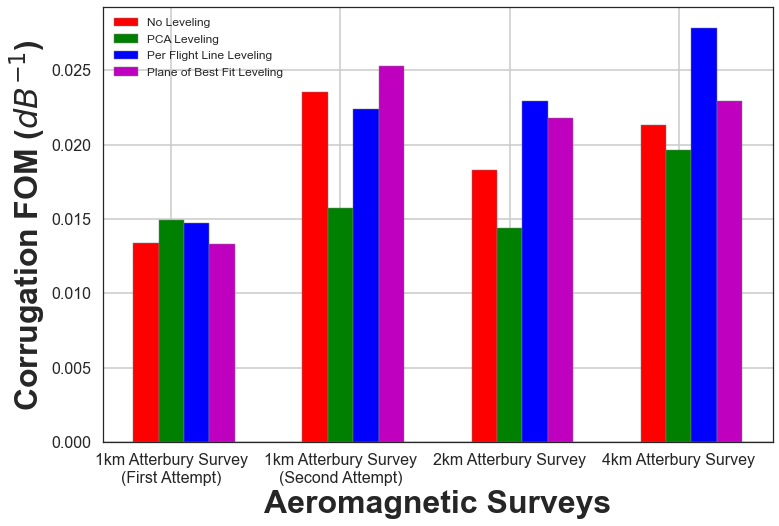

In [4]:
barWidth = 0.15
fig = plt.subplots(figsize =(12, 8))

none_bars   = [_1km_no_lvl_survey_1_fom,
               _1km_no_lvl_survey_2_fom,
               _2km_no_lvl_survey_fom,
               _4km_no_lvl_survey_fom]
pca_bars    = [_1km_pca_lvl_survey_1_fom,
               _1km_pca_lvl_survey_2_fom,
               _2km_pca_lvl_survey_fom,
               _4km_pca_lvl_survey_fom]
per_fl_bars = [_1km_per_flt_lvl_survey_1_fom,
               _1km_per_flt_lvl_survey_2_fom,
               _2km_per_flt_lvl_survey_fom,
               _4km_per_flt_lvl_survey_fom]
plane_bars  = [_1km_plane_lvl_survey_1_fom,
               _1km_plane_lvl_survey_2_fom,
               _2km_plane_lvl_survey_fom,
               _4km_plane_lvl_survey_fom]

br1 = np.arange(len(none_bars))
br2 = [x + barWidth for x in br1]
br3 = [x + barWidth for x in br2]
br4 = [x + barWidth for x in br3]

# Make the plot
plt.bar(br1, none_bars,   color ='r', width = barWidth, edgecolor ='grey', label ='No Leveling')
plt.bar(br2, pca_bars,    color ='g', width = barWidth, edgecolor ='grey', label ='PCA Leveling')
plt.bar(br3, per_fl_bars, color ='b', width = barWidth, edgecolor ='grey', label ='Per Flight Line Leveling')
plt.bar(br4, plane_bars,  color ='m', width = barWidth, edgecolor ='grey', label ='Plane of Best Fit Leveling')

# Adding Xticks
plt.xlabel('Aeromagnetic Surveys', fontweight ='bold', fontsize=32)
plt.ylabel('Corrugation FOM ($dB^{-1}$)',      fontweight ='bold', fontsize=32)
plt.xticks([r + barWidth for r in range(len(none_bars))],
           ['1km Atterbury Survey\n(First Attempt)', '1km Atterbury Survey\n(Second Attempt)', '2km Atterbury Survey', '4km Atterbury Survey'])

plt.grid()
plt.legend(fontsize='large')
plt.show()

# Map Correlations

**************************************************
2D Correlation Between
1km Atterbury Survey (First Attempt) PCA Line Leveled
and
1km Atterbury Survey (Second Attempt) Plane of Best Fit Leveled
Scalar Magnitudes
Max Scalar Pearson: 0.3881907465354701
Max Scalar Pearson Lags: [102, -6]
Zero Lag Scalar Pearson: -0.8834348885114223
Max dX Pearson: 0.5961616240255544
Max dX Pearson Lags: [80, 0]
Zero Lag dX Pearson: -0.05339229631899242
Max dY Pearson: 0.7580391323065421
Max dY Pearson Lags: [0, 0]
Zero Lag dY Pearson: 0.7580391323065421
**************************************************
2D Correlation Between
2km Atterbury Survey Per Flight Line Leveled
and
4km Atterbury Survey Per Flight Line Leveled
Scalar Magnitudes
Max Scalar Pearson: 0.6445899665944941
Max Scalar Pearson Lags: [0, -1]
Zero Lag Scalar Pearson: 0.6424424039327695
Max dX Pearson: 0.2655640797643319
Max dX Pearson Lags: [-85, -142]
Zero Lag dX Pearson: 0.041969658021214065
Max dY Pearson: 0.2979138377382414
Max dY Pear

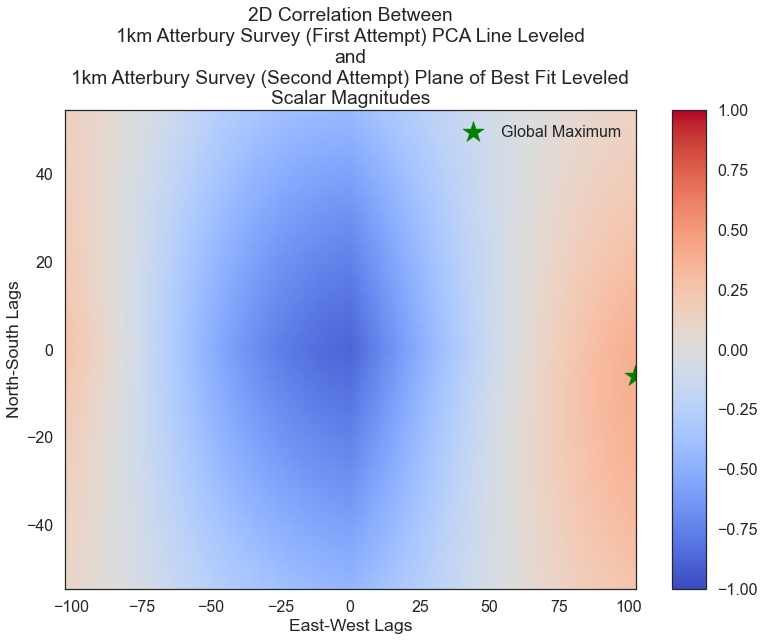

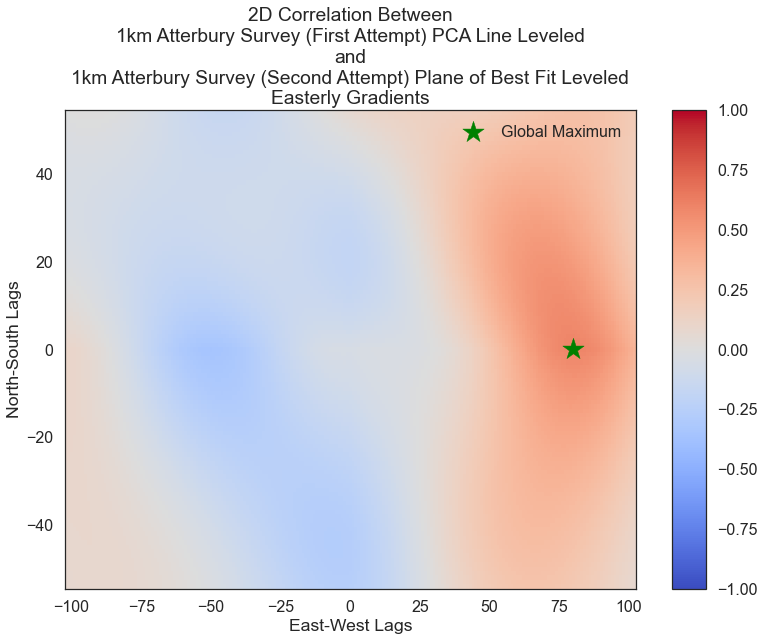

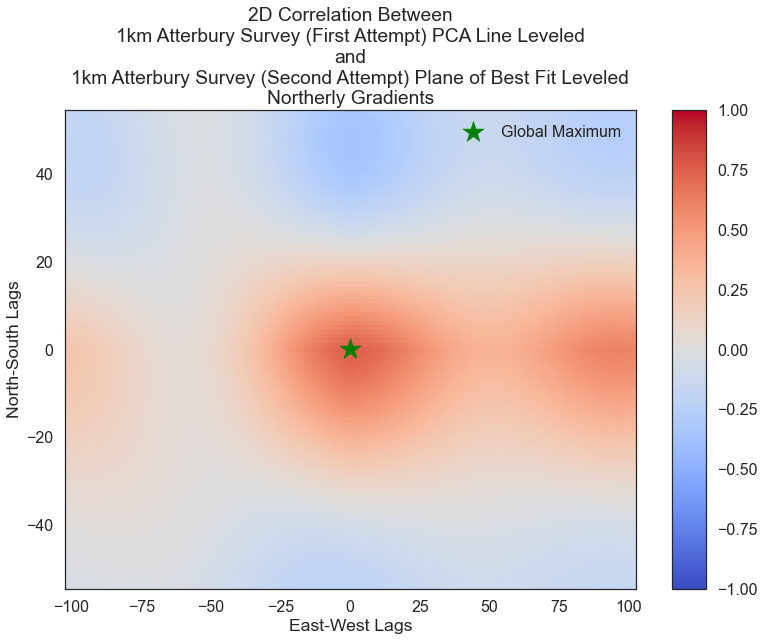

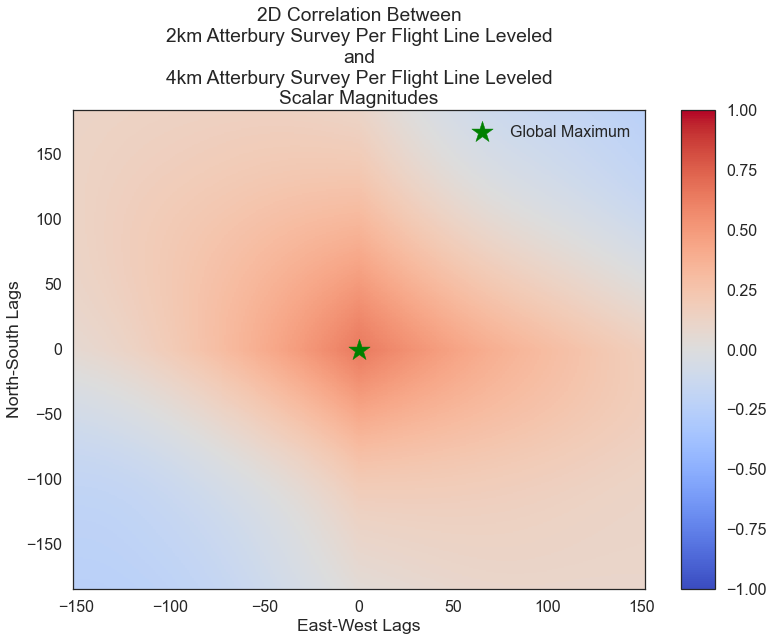

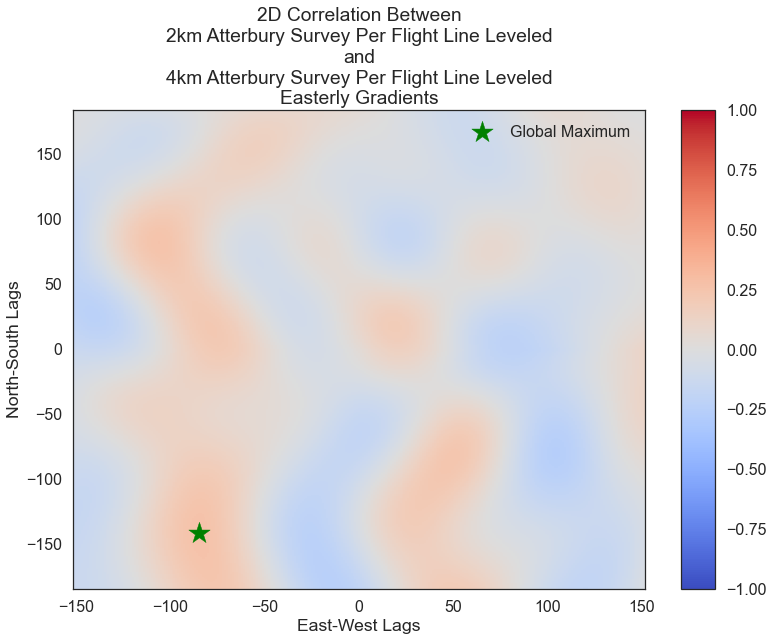

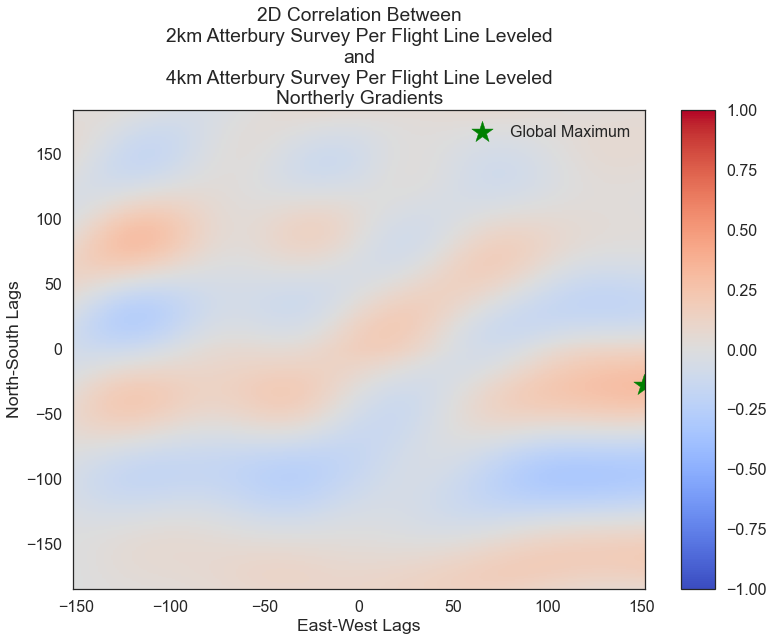

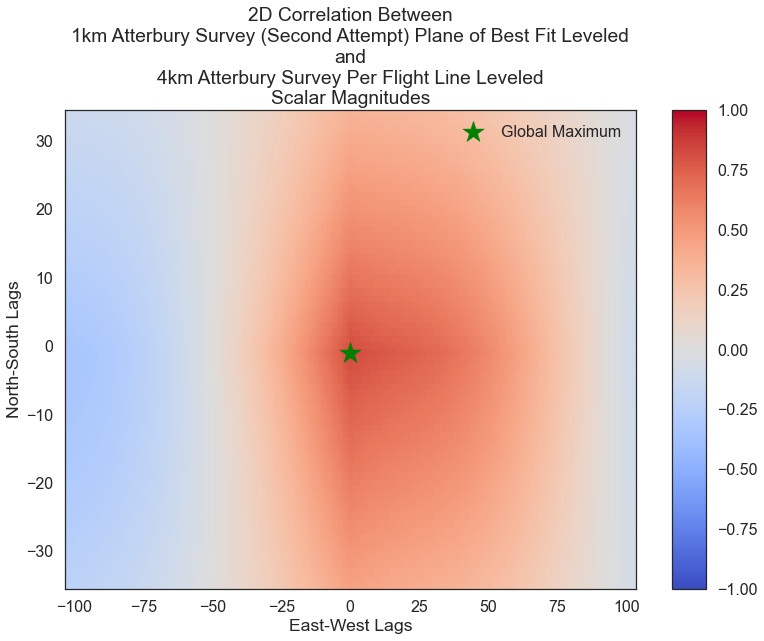

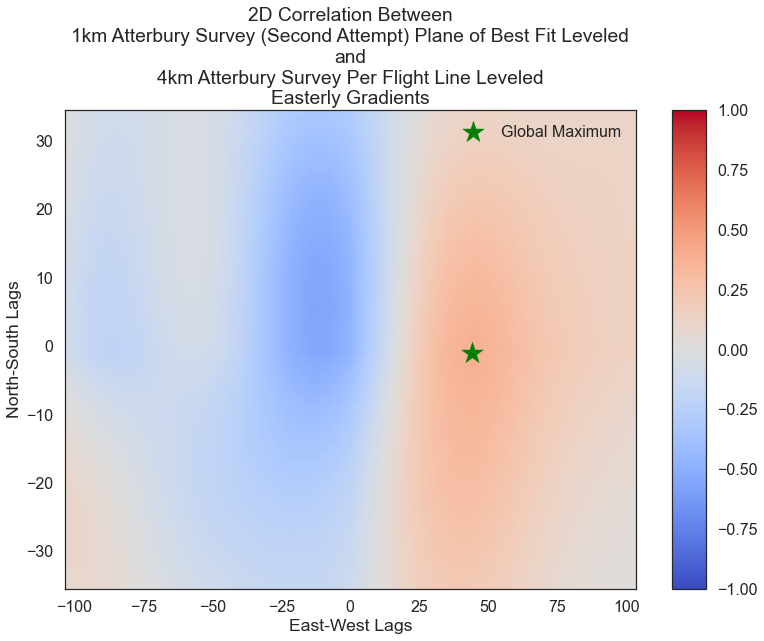

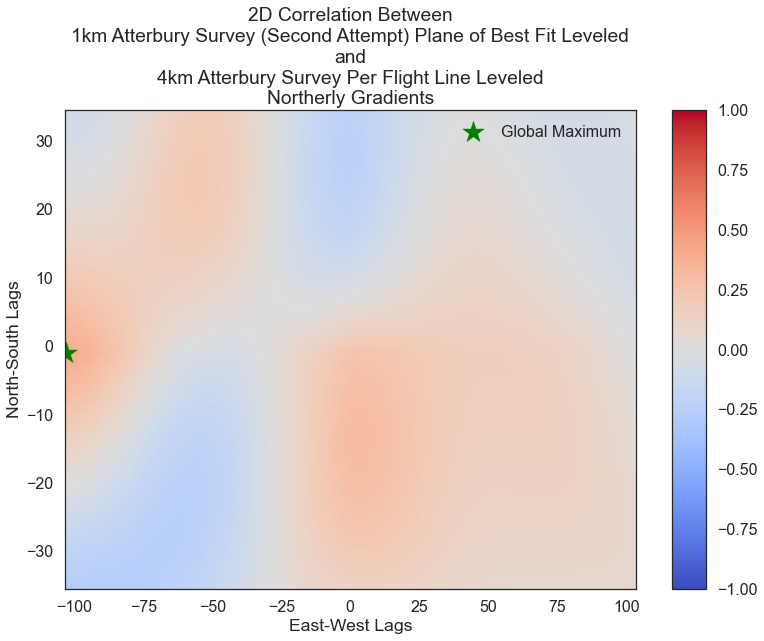

In [5]:
compare_maps(_1km_pca_lvl_survey_1,
             _1km_plane_lvl_survey_2,
             ref_map_name='1km Atterbury Survey (First Attempt) PCA Line Leveled',
             comp_map_name='1km Atterbury Survey (Second Attempt) Plane of Best Fit Leveled')
compare_maps(_2km_per_flt_lvl_survey,
             _4km_per_flt_lvl_survey,
             ref_map_name='2km Atterbury Survey Per Flight Line Leveled',
             comp_map_name='4km Atterbury Survey Per Flight Line Leveled')
compare_maps(_1km_per_flt_lvl_survey_2,
             _4km_per_flt_lvl_survey,
             ref_map_name='1km Atterbury Survey (Second Attempt) Plane of Best Fit Leveled',
             comp_map_name='4km Atterbury Survey Per Flight Line Leveled')